In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carrega a tabela imortação
imp_fert=pd.read_csv('~/git/BD/temp/imp_fert1.csv')

# Carrega a tabela com características adicionais de cada NCM
ncm_e=pd.read_csv('~/git/BD/Comexstat/tab_complementares/ncm_e.csv')

# Insere a data
imp_fert.insert(0,'date',pd.to_datetime(imp_fert.CO_ANO.astype(str)+'/'+imp_fert.CO_MES.astype(str)+'/1'))

# Funde as tabelas
imp_fert=ncm_e.merge(imp_fert)

# Ranqueia a seleciona os 10 maiores NCMs em peso
imp_fert_top=imp_fert.groupby('CO_NCM').KG_LIQUIDO.sum().sort_values(ascending=False).reset_index().head(10)['CO_NCM'].values

# Filtra a tabela deixano passar somente os registros dos NCMs top
imp_fert=imp_fert[imp_fert.CO_NCM.isin(imp_fert_top)]

imp_fert=imp_fert[(imp_fert.KG_LIQUIDO>0)&(imp_fert.VL_FOB>0)]

# Corrige erro do tipo aleatório que visualmente comprime os pesos na parte baixa do gráfico da ureia, sendo esse o único valor
# de potência 10**9 de todo o conjunto de dados.

# Crai tabela temporária somente com o registro do erro máximo
imp_fert_err=imp_fert[imp_fert.KG_LIQUIDO==imp_fert.KG_LIQUIDO.max()]

# Cria tabela temporária sem o erro registro do erro máximo
imp_fert_correto=imp_fert[imp_fert.KG_LIQUIDO!=imp_fert.KG_LIQUIDO.max()]

# Identifica data e NCM do erro
data_prdt_err=imp_fert_err[['date','CO_NCM']]

# Identifica registros sem erro na mesma data com o mesmo produto
imp_fert_correto_data_err=imp_fert_correto.merge(data_prdt_err)

# Calcula soma do valores e pesos corretos na data e para o produto do erro
imp_fert_correto_data_err=imp_fert_correto_data_err.groupby('CO_NCM')[['VL_FOB','KG_LIQUIDO']].sum()

# Cálcula o preço médio correto do produto na data do erro
preço_correção=(imp_fert_correto_data_err.VL_FOB / imp_fert_correto_data_err.KG_LIQUIDO).values[0]

# Cálcula o preço correto do produto na data do erro, e o insere na tabela com erro
#imp_fert_correto_data_err=imp_fert_correto_data_err.assign(preço=preço_correção)
#preço_correção=imp_fert_correto_data_err.preço.values[0]

# Através do valor importado, que já estava correto, e do preço corrigido, se determina o peso corrigido
imp_fert_err.loc[:,'KG_LIQUIDO']=round(imp_fert_err.VL_FOB / preço_correção)#.astype(int)

# Conclui a correção
imp_fert_corrigido=imp_fert_err

# Concatena importações corrigidas e originalmente corretas
imp_fert=pd.concat([imp_fert_corrigido,imp_fert_correto])

# Corrige inflação monetária

# Cria manualmente a tabela de correção do dólar
infl_dolar=pd.DataFrame({
 'CO_ANO':np.arange(1997,2025),
 'FATOR':[0.50,0.50,0.51,0.53,0.55,0.56,0.57,0.59,0.61,\
 0.63,0.64,0.67,0.67,0.68,0.70,0.72,0.73,0.74,\
 0.74,0.75,0.77,0.78,0.80,0.81,0.85,0.92,0.96,1.00]})

imp_fert=imp_fert.merge(infl_dolar)

#Armazena valor histórico em nova coluna
imp_fert['VL_FOB_corr']=imp_fert['VL_FOB']

# Atualiza valor monetário
imp_fert['VL_FOB_corr']=imp_fert['VL_FOB_corr']/imp_fert['FATOR']

imp_fert=imp_fert.rename(columns={'VL_FOB':'VL_FOB_hist','VL_FOB_corr':'VL_FOB'})

imp_fert=imp_fert.assign(date=pd.to_datetime(imp_fert.CO_ANO.astype(str)+'/'+imp_fert.CO_MES.astype(str)+'/1'))

imp_fert_l=pd.concat([imp_fert[['CO_NCM','date','VL_FOB']].assign(tipo='corrgido'),imp_fert[['CO_NCM','date','VL_FOB_hist']]\
                     .rename(columns={'VL_FOB_hist':'VL_FOB'}).assign(tipo='histórico')])
#imp_fert_l.date=imp_fert_l.date.astype(int)

imp_fert_l=imp_fert_l.sort_values('tipo',ascending=False)

# Filtra deixando passar somente  a via 1
imp_fert=imp_fert[imp_fert.CO_VIA==1]

# Descarta as colunas como previsto
imp_fert.drop(columns=['CO_VIA','CO_UNID','QT_ESTAT','FATOR'],inplace=True)

# NCM

### Clusterização pelo preço

# Determina o preço praticado em cada registro
imp_fert=imp_fert.assign(fob_kg=imp_fert.VL_FOB/imp_fert.KG_LIQUIDO)

imp_fert=imp_fert.assign(preço=(imp_fert.VL_FOB+imp_fert.VL_FRETE+imp_fert.VL_SEGURO)/imp_fert.KG_LIQUIDO)

In [2]:
imp_fert=imp_fert.sort_values(by='KG_LIQUIDO')

In [3]:
%run 'norm_20_bins.ipynb'


Função norm_20_bins() disponível.



In [4]:
col_target='preço'

In [5]:
# Clusteriza pelo preço
#r=pd.DataFrame()
ncm=31042090
imp_fert_t=imp_fert[imp_fert.CO_NCM==ncm].reset_index(drop=True)

In [15]:
q=pd.DataFrame()
r=pd.DataFrame()
for n in range(1,29):
    from sklearn.cluster import KMeans as KM
    KM=KM(n_clusters=n, n_init='auto', random_state=1)
    imp_fert_t2_km=imp_fert_t.assign(km=KM.fit_predict(imp_fert_t[['preço']])).assign(n_cluster=n)
    r=pd.concat([r,imp_fert_t2_km])
    
    km_top=imp_fert_t2_km.groupby('km').KG_LIQUIDO.sum().sort_values(ascending=False).reset_index().head(1)['km'][0]
    imp_fert_t2_km_top=imp_fert_t2_km[imp_fert_t2_km.km==km_top]
    ps=imp_fert_t2_km_top[col_target]
    normalidade=norm_20_bins(ps)
    
    imp_fert_t2_km_top_res=imp_fert_t2_km_top[['CO_NCM']].drop_duplicates()\
    .assign(norm=normalidade).assign(n_cluster=n).assign(count=len(imp_fert_t2_km_top)/len(imp_fert_t2_km))\
    .assign(kg_perc=imp_fert_t2_km_top.KG_LIQUIDO.sum()/imp_fert_t2_km.KG_LIQUIDO.sum())\
    .assign(km=km_top)
    display(imp_fert_t2_km_top_res)
    q=pd.concat([q,imp_fert_t2_km_top_res])

q=q.assign(norm_diff=q.diff().norm)

q=q[q.norm_diff==q.norm_diff.max()].merge(r)

q

,CO_NCM,norm,n_cluster,count,kg_perc,km
0,31042090,0.592121,1,1.0,1.0,0


,CO_NCM,norm,n_cluster,count,kg_perc,km
0,31042090,0.589046,2,0.999648,1.0,0


,CO_NCM,norm,n_cluster,count,kg_perc,km
0,31042090,0.593092,3,0.999648,1.0,0


,CO_NCM,norm,n_cluster,count,kg_perc,km
22,31042090,0.598735,4,0.991793,1.0,0


,CO_NCM,norm,n_cluster,count,kg_perc,km
22,31042090,0.605736,5,0.991266,1.0,0


,CO_NCM,norm,n_cluster,count,kg_perc,km
29,31042090,0.627013,6,0.989976,1.0,0


,CO_NCM,norm,n_cluster,count,kg_perc,km
29,31042090,0.622158,7,0.989976,1.0,0


,CO_NCM,norm,n_cluster,count,kg_perc,km
99,31042090,0.694234,8,0.983117,0.999998,0


,CO_NCM,norm,n_cluster,count,kg_perc,km
99,31042090,0.689225,9,0.983117,0.999998,0


,CO_NCM,norm,n_cluster,count,kg_perc,km
99,31042090,0.691541,10,0.982707,0.999998,0


,CO_NCM,norm,n_cluster,count,kg_perc,km
303,31042090,0.881855,11,0.817692,0.848765,0


,CO_NCM,norm,n_cluster,count,kg_perc,km
303,31042090,0.880691,12,0.807257,0.837582,0


,CO_NCM,norm,n_cluster,count,kg_perc,km
303,31042090,0.878486,13,0.817692,0.848765,0


,CO_NCM,norm,n_cluster,count,kg_perc,km
303,31042090,0.885618,14,0.802568,0.833008,0


,CO_NCM,norm,n_cluster,count,kg_perc,km
303,31042090,0.885034,15,0.802568,0.833008,0


,CO_NCM,norm,n_cluster,count,kg_perc,km
303,31042090,0.886714,16,0.802568,0.833008,0


,CO_NCM,norm,n_cluster,count,kg_perc,km
303,31042090,0.883135,17,0.802568,0.833008,0


,CO_NCM,norm,n_cluster,count,kg_perc,km
324,31042090,0.892851,18,0.688786,0.719906,0


,CO_NCM,norm,n_cluster,count,kg_perc,km
324,31042090,0.890553,19,0.688786,0.719906,0


,CO_NCM,norm,n_cluster,count,kg_perc,km
391,31042090,0.897416,20,0.680579,0.712212,0


,CO_NCM,norm,n_cluster,count,kg_perc,km
391,31042090,0.89245,21,0.678586,0.710538,0


,CO_NCM,norm,n_cluster,count,kg_perc,km
391,31042090,0.890726,22,0.673779,0.705353,0


,CO_NCM,norm,n_cluster,count,kg_perc,km
391,31042090,0.890882,23,0.673134,0.704685,0


,CO_NCM,norm,n_cluster,count,kg_perc,km
391,31042090,0.889663,24,0.673134,0.704685,0


,CO_NCM,norm,n_cluster,count,kg_perc,km
391,31042090,0.894732,25,0.675479,0.70721,0


,CO_NCM,norm,n_cluster,count,kg_perc,km
391,31042090,0.888309,26,0.673369,0.70476,0


,CO_NCM,norm,n_cluster,count,kg_perc,km
391,31042090,0.893532,27,0.673369,0.70476,0


,CO_NCM,norm,n_cluster,count,kg_perc,km
425,31042090,0.866405,28,0.508119,0.495611,27


,CO_NCM,norm,n_cluster,count,kg_perc,km,norm_diff,name,NO_NCM_POR,média,...,CO_PAIS,SG_UF_NCM,CO_URF,KG_LIQUIDO,VL_FOB_hist,VL_FRETE,VL_SEGURO,VL_FOB,fob_kg,preço
0,31042090,0.881855,11,0.817692,0.848765,0,0.190314,Outros cloretos de potássio,Outros cloretos de potássio,1.129774e+07,...,23,RJ,717600,2100,470,129,3,9.400000e+02,0.447619,0.510476
1,31042090,0.881855,11,0.817692,0.848765,0,0.190314,Outros cloretos de potássio,Outros cloretos de potássio,1.129774e+07,...,158,PR,925251,4000,1246,158,30,1.832353e+03,0.458088,0.505088
2,31042090,0.881855,11,0.817692,0.848765,0,0.190314,Outros cloretos de potássio,Outros cloretos de potássio,1.129774e+07,...,23,RS,1010500,10500,2363,840,20,4.726000e+03,0.450095,0.532000
3,31042090,0.881855,11,0.817692,0.848765,0,0.190314,Outros cloretos de potássio,Outros cloretos de potássio,1.129774e+07,...,403,RJ,717600,23136,5928,996,0,9.718033e+03,0.420039,0.463089
4,31042090,0.881855,11,0.817692,0.848765,0,0.190314,Outros cloretos de potássio,Outros cloretos de potássio,1.129774e+07,...,383,CE,817800,24000,10492,387,3,1.295309e+04,0.539712,0.555962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13944,31042090,0.881855,11,0.817692,0.848765,0,0.190314,Outros cloretos de potássio,Outros cloretos de potássio,1.129774e+07,...,149,PR,917800,144217335,46782916,4415349,35991,4.873220e+07,0.337908,0.368774
13945,31042090,0.881855,11,0.817692,0.848765,0,0.190314,Outros cloretos de potássio,Outros cloretos de potássio,1.129774e+07,...,149,PR,917800,150811086,49895054,3801464,32651,6.236882e+07,0.413556,0.438979
13946,31042090,0.881855,11,0.817692,0.848765,0,0.190314,Outros cloretos de potássio,Outros cloretos de potássio,1.129774e+07,...,149,SP,817800,151238000,55540519,6769017,34536,6.534179e+07,0.432046,0.477032
13947,31042090,0.881855,11,0.817692,0.848765,0,0.190314,Outros cloretos de potássio,Outros cloretos de potássio,1.129774e+07,...,149,RS,1017700,170446360,51416919,8333596,24183,5.355929e+07,0.314230,0.363264


In [16]:
q_l=pd.concat([q.assign(tipo='limpo'),imp_fert_t.assign(tipo='orig')])

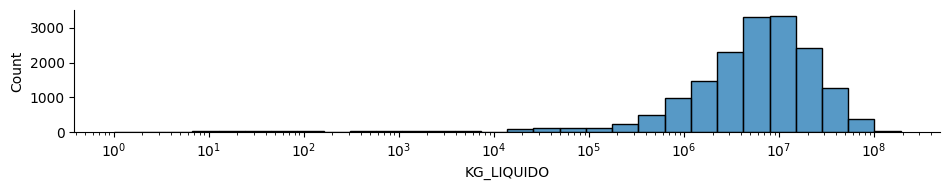

In [27]:
sns.displot(data=imp_fert_t2_km,x='KG_LIQUIDO',log_scale=True,bins=30,height=2,aspect=3*1.6)

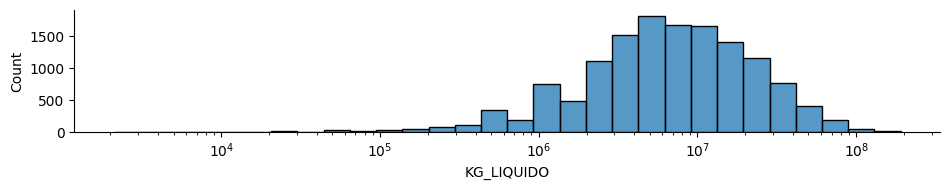

In [24]:
sns.displot(data=q,x='KG_LIQUIDO',log_scale=True,bins=30,height=2,aspect=3*1.6)

In [9]:
a=

SyntaxError: invalid syntax (62411553.py, line 1)

In [ ]:
#r=pd.concat([r,q])

q[['CO_NCM','n_cluster','norm']]

In [ ]:
a=

In [ ]:
km_sel=pd.DataFrame({'name':['NP','MAP','NPK','Outros cloretos de potássio','Outros superfosfatos','NAM','SAM','ureia'],
             'n':[6,22,22,26,6,18,26,18]})

In [ ]:
imp_fert_km_sel=imp_fert_km.merge(km_sel)

In [ ]:
rank_correto=imp_fert_km_sel.groupby(by=['name','km']).KG_LIQUIDO.sum().reset_index().sort_values(by=['name','KG_LIQUIDO'],ascending=False)
rank_correto=rank_correto.groupby(by=['name']).KG_LIQUIDO.max().reset_index().merge(rank_correto)

In [ ]:
imp_fert_km_sel_correto=imp_fert_km_sel.merge(rank_correto[['name','km']])

In [ ]:
imp_fert_km_sel_erro=imp_fert_km_sel[~imp_fert_km_sel.index.isin(imp_fert_km_sel_correto.index)]

In [ ]:
len(imp_fert_km_sel_erro)/len(imp_fert_km_sel_correto)*100

In [ ]:
imp_fert_km_sel_erro.KG_LIQUIDO.sum()/imp_fert_km_sel_correto.KG_LIQUIDO.sum()*100

In [ ]:
imp_fert_km_sel_erro.VL_FOB.sum()/imp_fert_km_sel_correto.VL_FOB.sum()*100

In [ ]:
imp_fert_km_sel_erro=imp_fert_km_sel_erro.assign(erro_kg=0)
imp_fert_km_sel_erro.loc[imp_fert_km_sel_erro.KG_LIQUIDO<10**3.1,'erro_kg']=1

In [ ]:
imp_fert_km_sel_erro=imp_fert_km_sel_erro.assign(erro_vl=0)
imp_fert_km_sel_erro.loc[imp_fert_km_sel_erro.VL_FOB<10**3.2,'erro_vl']=1

In [ ]:
imp_fert_km_sel_erro=imp_fert_km_sel_erro.assign(descarte=0)
imp_fert_km_sel_erro.loc[(imp_fert_km_sel_erro.erro_kg==1)&(imp_fert_km_sel_erro.erro_vl==1),'descarte']=1

In [ ]:
imp_fert_km_sel_erro_limpo=imp_fert_km_sel_erro[imp_fert_km_sel_erro.descarte==0].drop(columns='descarte')

In [ ]:
len(imp_fert_km_sel_erro_limpo)/len(imp_fert_km_sel)*100

In [ ]:
imp_fert_km_sel_erro_limpo.KG_LIQUIDO.sum()/imp_fert_km_sel.KG_LIQUIDO.sum()*100

In [ ]:
imp_fert_km_sel_erro_limpo.VL_FOB.sum()/imp_fert_km_sel.VL_FOB.sum()*100

In [ ]:
len(imp_fert_km_sel_correto)/len(imp_fert_km_sel)*100

In [ ]:
imp_fert_km_sel_correto.KG_LIQUIDO.sum()/imp_fert_km_sel.KG_LIQUIDO.sum()*100

In [ ]:
imp_fert_km_sel_correto.VL_FOB.sum()/imp_fert_km_sel.VL_FOB.sum()*100

In [ ]:
i_f_km_s_c=imp_fert_km_sel_correto

In [ ]:
# Determina características dos clusters para identificação deles posteriormente
q=pd.DataFrame()
for ncm in i_f_km_s_c.CO_NCM.unique():
    i_f_km_s_c_t=i_f_km_s_c[i_f_km_s_c.CO_NCM==ncm]
    i_f_km_s_c_t=i_f_km_s_c_t.assign(média=i_f_km_s_c_t.KG_LIQUIDO.mean())
    i_f_km_s_c_t=i_f_km_s_c_t.assign(std=i_f_km_s_c_t.KG_LIQUIDO.std())
    q=pd.concat([q,i_f_km_s_c_t])
i_f_km_s_c=q

In [ ]:
m_s=i_f_km_s_c[['name','média','std']].drop_duplicates()

ncm_e=ncm_e.merge(m_s,how='left')

# Salva nova tabela de ncm expandida
ncm_e.to_csv('~/git/BD/Comexstat/tab_complementares/ncm_e.csv',index=False)

In [ ]:
i_f_km_s_c.to_csv('~/git/BD/temp/imp_fert2.csv',index=False)

In [ ]:
sns.displot(data=imp_fert_km_sel_correto,x='KG_LIQUIDO',log_scale=True,col='name', bins=20, facet_kws=dict(sharex=False, sharey=False))
plt.show()

In [ ]:
sns.displot(data=imp_fert_km_sel_correto,x='VL_FOB',log_scale=True,col='name', bins=20, facet_kws=dict(sharex=False, sharey=False))
plt.show()